In [1]:
import tensorflow as tf
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

import time


/home/milos/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# IOU calculation

In [2]:
# set data you want to analyze
dataset_part4eval = "testing" # "testing" or "validation"

# set model to be used for inference
inference_graph_path = "./logs/FCN8_v2.TL_True.1.2k_images.res_224.learning_rate=1e-05.dropout=0.9.training_iter=0.8M.batch_size=16.cost_softmax_cross_entropy.rot_True.flip_True.crop_True.gauss_True.fixed_standardization_False/frozen_graph.pb"
#inference_graph_path = "./logs/linkNet.TL_False.1.2k_images.res_224.learning_rate=1e-05.dropout=1.0.training_iter=0.8M.batch_size=8.cost_softmax_cross_entropy.rot_True.flip_True.crop_True.gauss_True.fixed_standardization_False/frozen_graph.pb"
#inference_graph_path = "./logs/tiramisu103.TL_False.1.2k_images.res_224.learning_rate=1e-05.dropout=0.95.training_iter=0.8M.batch_size=4.cost_softmax_cross_entropy.rot_True.flip_True.crop_True.gauss_True.fixed_standardization_False/frozen_graph.pb"
#inference_graph_path = "./logs/u_net_v1.TL_False.1.2k_images.res_228.learning_rate=1e-05.dropout=0.9.training_iter=0.8M.batch_size=8.cost_softmax_cross_entropy.rot_True.flip_True.crop_True.gauss_True.fixed_standardization_False/frozen_graph.pb"

model_name = inference_graph_path.split('/')[2].split('.')[0]
if model_name == 'u_net_v1':
    input_size = 228
else:
    input_size = 224

dataset_imgs_path = os.path.join("./dataset/DATA/images",dataset_part4eval)
dataset_anns_path = os.path.join("./dataset/DATA/annotations",dataset_part4eval)

imgs_path = glob.glob(dataset_imgs_path+'/*.png')
anns_path = glob.glob(dataset_anns_path+'/*.png')



In [3]:
def get_IOUs(ann_gt,ann_pred):
    TP = np.sum(ann_gt*ann_pred)
    FNplusTP = np.sum(ann_gt) 
    FPplusTP = np.sum(ann_pred)
    IOU_product = TP/(FNplusTP+FPplusTP-TP)
    
    TN = np.sum((ann_gt==0)*(ann_pred==0))
    TNplusFP = np.sum(ann_gt==0)
    TNplusFN = np.sum(ann_pred==0)
    IOU_background = TN/(TNplusFP+TNplusFN-TN)
    
    IOU_mean = (IOU_product + IOU_background)/2
    
    return IOU_mean,IOU_product


In [4]:
NUM_OF_CLASSESS = 2
tf.reset_default_graph()

iou_mean_curr_global = 0
iou_product_curr_global =  0

with tf.gfile.GFile(name=inference_graph_path,mode='rb') as f:
    input_graph_def = tf.GraphDef()
    input_graph_def.ParseFromString(f.read())
    
graph = tf.get_default_graph()

with tf.Session() as sess:
    tf.import_graph_def(input_graph_def,name='import')

    image = graph.get_tensor_by_name('import/input_image:0')
    pred_annotation = graph.get_tensor_by_name('import/inference/prediction:0')    
    keep_probability = graph.get_tensor_by_name('import/keep_probabilty:0')
    TRAINING = graph.get_tensor_by_name('import/TRAINING:0')
    annotation = tf.placeholder(dtype=tf.int32,shape=[None,input_size,input_size,1])
    
    with tf.name_scope('metrics') as scope:
        iou_mean, cm_update_op = tf.metrics.mean_iou(labels=annotation, predictions=tf.expand_dims(pred_annotation,axis=3), num_classes=NUM_OF_CLASSESS)
        conf_mat = tf.Variable(initial_value=np.zeros([NUM_OF_CLASSESS,NUM_OF_CLASSESS]),name='confusion_matrix')
        iou_background = tf.divide(conf_mat[0,0],tf.subtract(tf.add(tf.reduce_sum(conf_mat,0)[0],tf.reduce_sum(conf_mat,1)[0]),conf_mat[0,0]),name='iou_background')
        iou_product =      tf.divide(conf_mat[1,1],tf.subtract(tf.add(tf.reduce_sum(conf_mat,0)[1],tf.reduce_sum(conf_mat,1)[1]),conf_mat[1,1]),name='iou_product') 
        
        
    img_path_list = []
    IOU_mean_list = []
    IOU_product_list = []
    img_list = [] 
    true_ann_list = []
    pred_ann_list = []
    
    metrics_vars = [v for v in tf.local_variables() if 'metrics' in v.name]
    sess.run(tf.variables_initializer(metrics_vars))    
        
    for idx in range(len(imgs_path)):
        start_time = time.time()
        
        img_path = imgs_path[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(input_size,input_size))
        
        ann_path = anns_path[idx]
        ann = cv2.imread(ann_path)
        ann = cv2.resize(ann,(input_size,input_size))
        ann = ann[:,:,0]
        ann = np.expand_dims(ann,2)         
        
        feed_dict={image:np.expand_dims(img,0), keep_probability:1.0, TRAINING:False, annotation:np.expand_dims(ann,0)}
        cm, pred_ann = sess.run([cm_update_op,pred_annotation], feed_dict=feed_dict)
       
        iou_mean_curr_global = iou_mean.eval()
        conf_mat.load(cm, sess)
        iou_product_curr_global =  iou_product.eval() 
      
        iou_mean_curr, iou_product_curr = get_IOUs(ann.squeeze(),pred_ann.squeeze())
        
        IOU_mean_list.append(iou_mean_curr)  
        IOU_product_list.append(iou_product_curr)  
        img_list.append(img)
        pred_ann_list.append(pred_ann[0].astype(np.uint8))
        true_ann_list.append(ann.squeeze(2))
        img_path_list.append(imgs_path[idx]) 
        
       
print('IoU (cumulative matrix): %f'%iou_mean_curr_global)
print('Gland IoU (cumulative matrix): %f'%iou_product_curr_global)

print('Average IoU: %f'%np.nanmean(IOU_mean_list))
print('Average gland IoU: %f'%np.nanmean(IOU_product_list))

IoU (cumulative matrix): 0.916904
Gland IoU (cumulative matrix): 0.852852
Average IoU: 0.912634
Average gland IoU: 0.844351


# Print 10 worst IoU values

In [5]:
indices = sorted(range(len(IOU_product_list)), key=lambda k: IOU_product_list[k])[0:10]
[{img_path_list[idx].split('/')[-1]:IOU_product_list[idx]} for idx in indices]

[{'249_BORSETTO_0005.png': 0.4233704292527822},
 {'164_STELLIN_0005.png': 0.45554445554445555},
 {'5_GALLAS_0003.png': 0.47845303867403316},
 {'264_CIMETTA_0005.png': 0.4965826569841948},
 {'344_MAIERO_0005.png': 0.591869591467096},
 {'344_IMG-0001-00007.png': 0.6035196687370601},
 {'220_GORI_0002.png': 0.6173506119510439},
 {'133_IMG-0001-00007.png': 0.6210097926999872},
 {'11_VIT_0008.png': 0.6371134020618556},
 {'152_IMG-0001-00008.png': 0.6439172240802675}]

# Print IOU values for given images

In [6]:
IOU_product_list[[path.split('/')[-1] for path in img_path_list].index('11_¡mg420.png')]

0.9399434370321078

In [7]:
IOU_product_list[[path.split('/')[-1] for path in img_path_list].index('244_IMG-0001-00007.png')]

0.6629637392580172

In [8]:
IOU_product_list[[path.split('/')[-1] for path in img_path_list].index('164_STELLIN_0005.png')]

0.45554445554445555

In [9]:
IOU_product_list[[path.split('/')[-1] for path in img_path_list].index('371_¡mg043.png')]

0.9424644398273934

# Plot input image, predicted annotations and ground truth annotations 

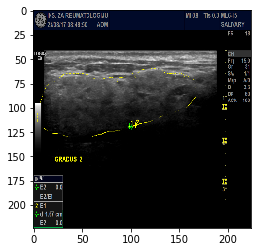

In [10]:
plt.imshow(img_list[1])

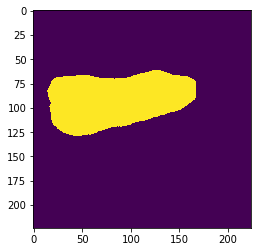

In [11]:
plt.imshow(pred_ann_list[1])

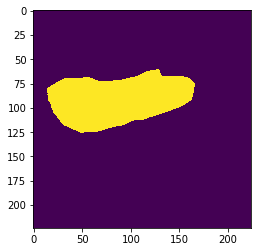

In [12]:
plt.imshow(true_ann_list[1])

# IoU histograms

(0, 1)

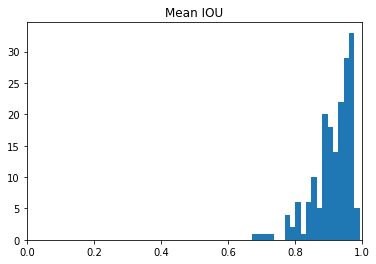

In [13]:
plt.hist(IOU_mean_list,bins=20)
plt.title('Mean IOU')
plt.xlim((0,1))


(0, 1)

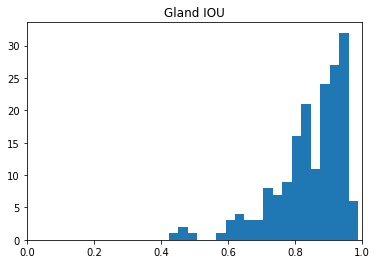

In [14]:
plt.hist(IOU_product_list,bins=20)
plt.title('Gland IOU')
plt.xlim((0,1))


# Store images to be checked

In [15]:
for idx in range(len(IOU_product_list)):
    img = img_list[idx]
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    ann = np.zeros(shape=[input_size,input_size,3],dtype=np.uint8)
    ann[:,:,0] = true_ann_list[idx]
    ann[:,:,1] = true_ann_list[idx]
    ann[:,:,2] = true_ann_list[idx]
   
    pred_ann = np.zeros(shape=[input_size,input_size,3],dtype=np.uint8)
    pred_ann[:,:,0] = pred_ann_list[idx]
    pred_ann[:,:,1] = pred_ann_list[idx]
    pred_ann[:,:,2] = pred_ann_list[idx]
    
    prediction_img = np.zeros([input_size,input_size,3])
    gt = (pred_ann[:,:,0]==1) * (ann[:,:,0]==1)
    fp = (pred_ann[:,:,0]==1) * (ann[:,:,0]==0)
    fn = (pred_ann[:,:,0]==0) * (ann[:,:,0]==1)
    prediction_img[gt] = [0,255,0]
    prediction_img[fp] = [0,0,255]
    prediction_img[fn] = [0,255,255]    
    
    merged_image = np.zeros(shape=[input_size,input_size*2+20,3])+100
   
    merged_image[0:input_size,0:input_size,:] = img
    merged_image[0:input_size,input_size+20:input_size*2+20,:] = prediction_img
    merged_image = merged_image.astype(np.uint8)
    
    out_path = os.path.join('./worst_predictions',dataset_part4eval,model_name,'merged_'+ img_path_list[idx].split('/')[-1])
    cv2.imwrite(out_path,merged_image)
    